In [4]:
import pandas as pd

# Load the dataset
pga_data = pd.read_excel('Tour data/PGA_tour_data.xlsx')

# Extract column names for reference
column_names = pga_data.columns

# Initialise a list to hold each player's data
all_players_data = []

# Iterate through each row in the DataFrame
for _, row in pga_data.iterrows():
    # Extract tournament name for reuse in each player's data
    tournament = row['TOURNAMENT']
    
    # Iterate over columns, starting from the first 'PLAYER' column and skipping every other column
    for i in range(1, len(column_names), 2):  # Starting at 1 to skip the 'TOURNAMENT' column, increment by 2 for each 'PLAYER' column
        # Check if we're not at the last column to avoid index out of range
        if i + 1 < len(column_names):
            player_column = column_names[i]
            stat_column = column_names[i + 1]
            
            # Create a dictionary for the player's data
            player_data = {
                'Tournament': tournament,
                'Player': row[player_column],
                'Stat_Name': stat_column,
                'Stat_Value': row[stat_column]
            }
            
            # Append the player's data to the list
            all_players_data.append(player_data)

# Convert the list to a DataFrame
organised_df = pd.DataFrame(all_players_data)

# Save the DataFrame to an Excel file
#organised_df.to_excel('Tour data/organised_PGA_tour_data_final.xlsx', index=False)

# First, ensure 'Stat_Name' and 'Stat_Value' are suitable for pivoting
organised_df['Stat_Name'] = organised_df['Stat_Name'].str.replace('PLAYER ', '')

# Pivot the table to have one row per player per tournament, with stats as columns
pivot_df = organised_df.pivot_table(
    index=['Tournament', 'Player'],
    columns='Stat_Name',
    values='Stat_Value',
    aggfunc='first'  # Use 'first' to deal with potential duplicates
).reset_index()

# Optionally, rename the columns to remove multi-level indexing after pivoting
pivot_df.columns.name = None  # Remove the columns name 'Stat_Name'
pivot_df = pivot_df.rename_axis(None, axis=1)

# Define a function to convert a string from feet and inches to inches
def convert_to_inches(feet_inches_str):
    if pd.isna(feet_inches_str):
        return None  # Handle missing values
    
    # Check if the value is a string and contains the expected format
    if isinstance(feet_inches_str, str) and '\'' in feet_inches_str:
        parts = feet_inches_str.split('\'')
        feet = int(parts[0])
        inches = int(parts[1].replace('"', '')) if len(parts) > 1 else 0
        return 12 * feet + inches
    elif isinstance(feet_inches_str, (int, float)):
        # Handle numeric inputs assuming they're already in inches
        return feet_inches_str
    else:
        # Return None or raise an error for unhandled types
        return None

def standardise_percentage(value):
    if pd.isna(value):
        return None  # Handle missing values
    if 0 < value < 1:  # Assuming values intended as percentages are between 0 and 1
        return value * 100
    else:
        return value

# List of columns that record percentages
percentage_columns = ["% PUTTS MADE INSIDE 10'", '3 PUTT %', 'BIRDIE CONVERSION %','BIRDIE OR BETTER %','DRIVING ACCURACY %','GIR %','SAND SAVE %','SCRAMBLING %']  # Replace these with your actual column names

# Apply the standardization function to each percentage column
for column in percentage_columns:
    pivot_df[column] = pivot_df[column].apply(standardise_percentage)

# Apply the conversion function to the 'Proximity to Hole' column
pivot_df['AVG PROXIMITY TO HOLE'] = pivot_df['AVG PROXIMITY TO HOLE'].apply(convert_to_inches)

# Save the reorganized DataFrame to an Excel file
pivot_df.to_excel('Tour data/organized_PGA_tour_data_final.xlsx', index=False)



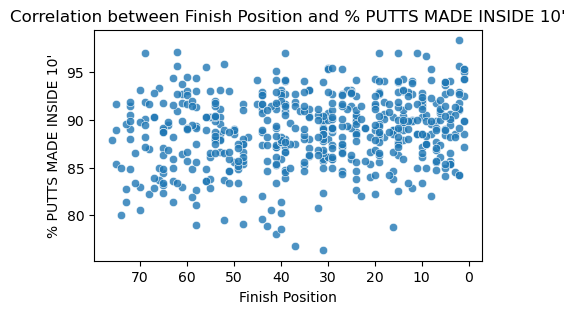

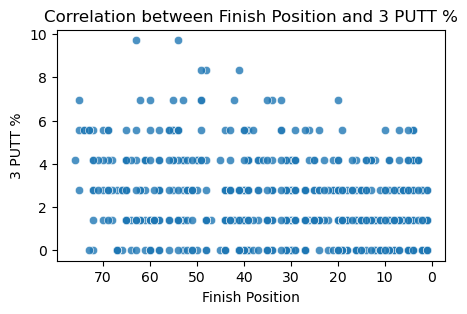

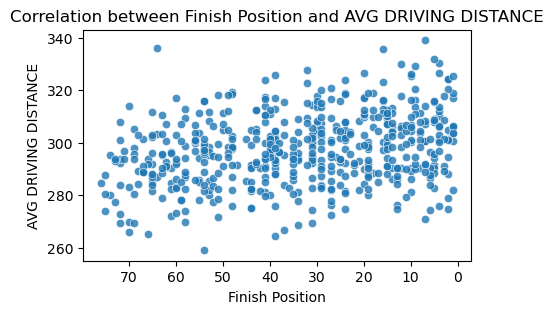

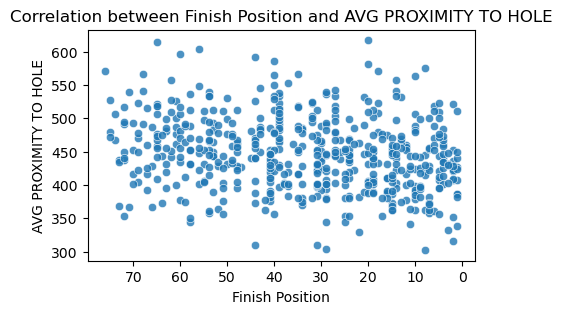

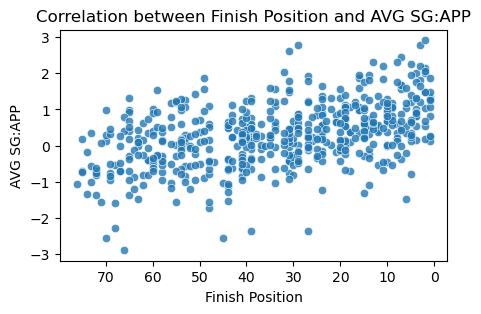

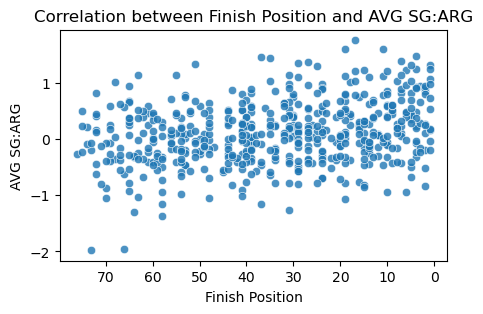

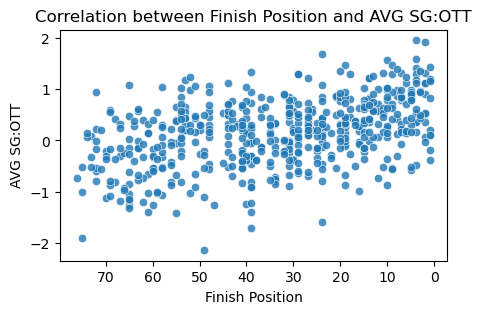

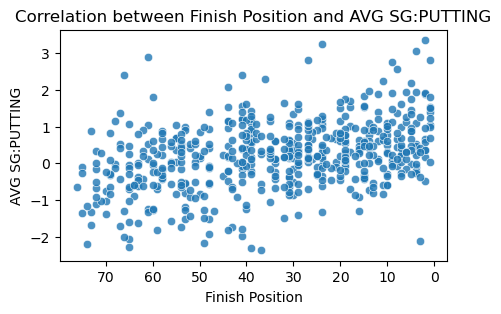

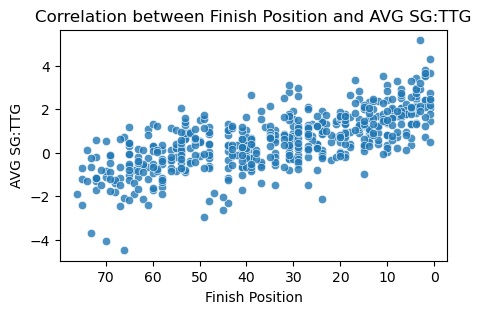

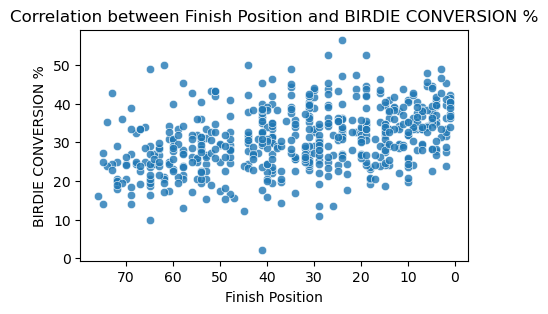

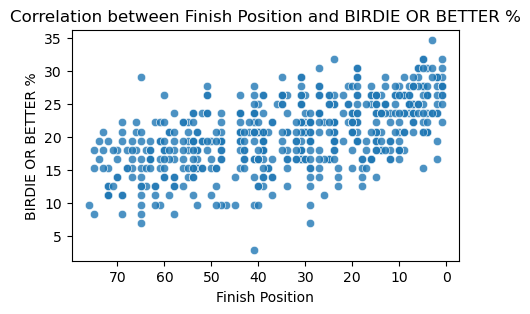

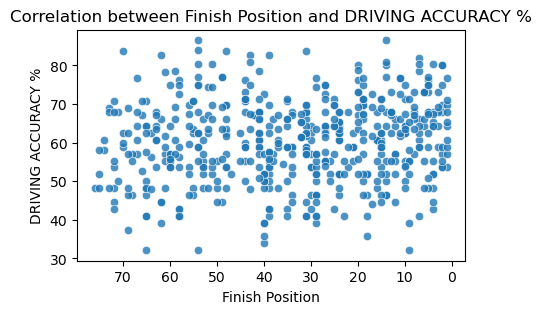

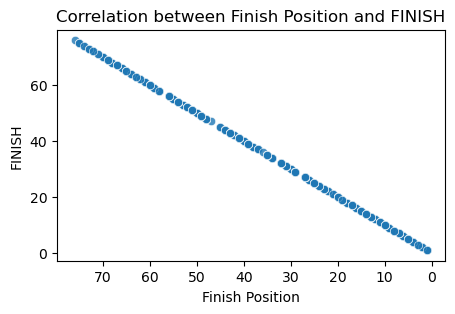

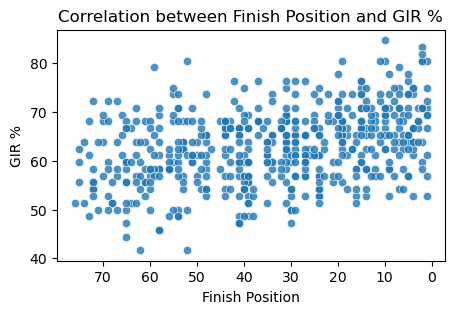

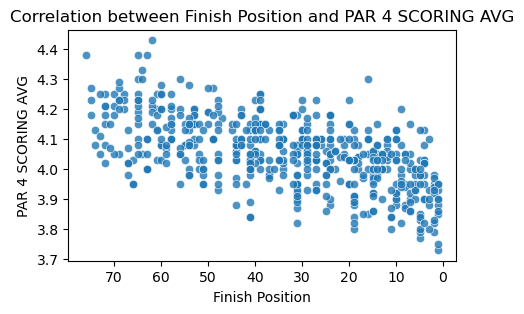

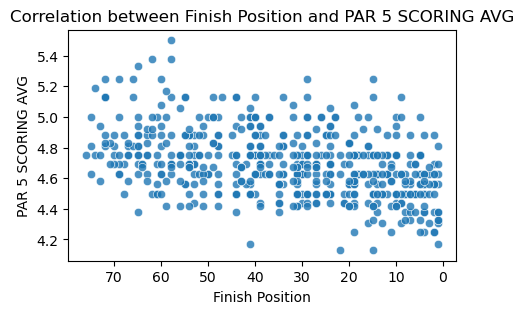

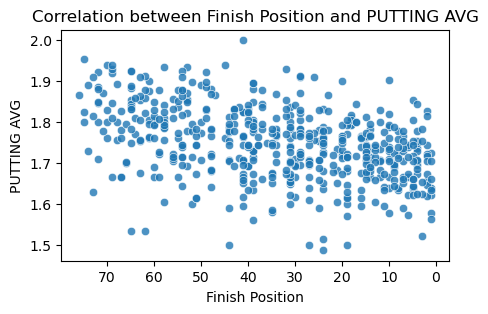

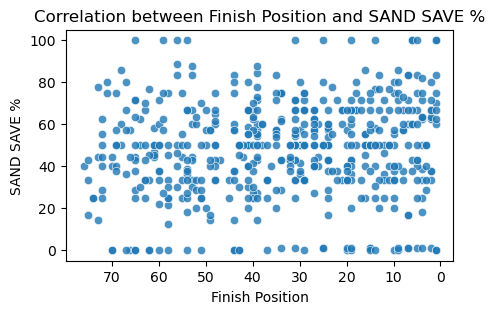

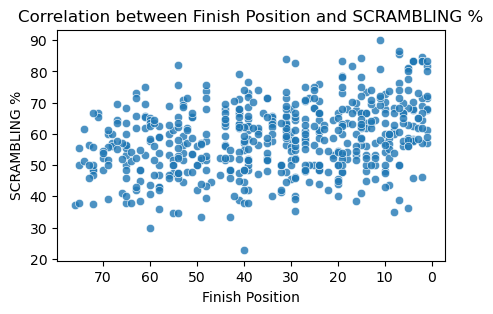

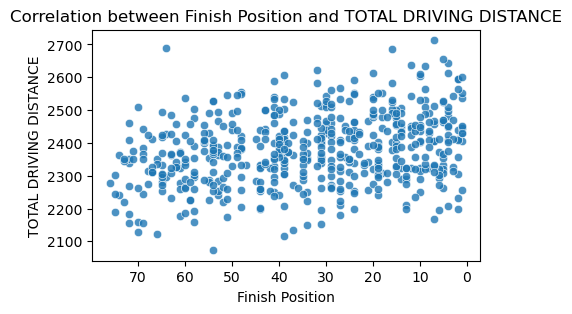

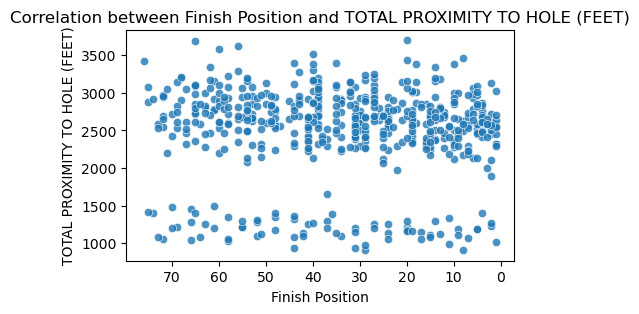

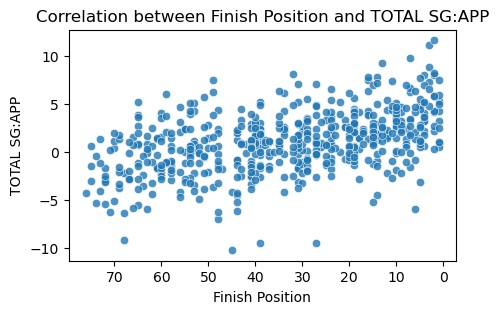

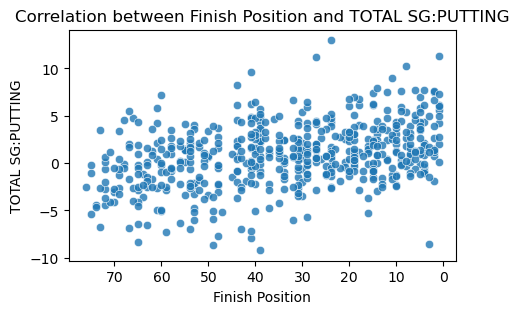

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the pivoted DataFrame
df = pd.read_excel('Tour data/organized_PGA_tour_data_final.xlsx')

# Select relevant columns (statistics)
all_stats = df[["% PUTTS MADE INSIDE 10'", "3 PUTT %", "AVG DRIVING DISTANCE", "AVG PROXIMITY TO HOLE", "AVG SG:APP",
                "AVG SG:ARG", "AVG SG:OTT", "AVG SG:PUTTING", "AVG SG:TTG", "BIRDIE CONVERSION %", "BIRDIE OR BETTER %",
                "DRIVING ACCURACY %", "GIR %", "PAR 4 SCORING AVG", "PAR 5 SCORING AVG", "PUTTING AVG",
                "SAND SAVE %", "SCRAMBLING %", "TOTAL DRIVING DISTANCE", "TOTAL PROXIMITY TO HOLE (FEET)",
                "TOTAL SG:APP", "TOTAL SG:PUTTING"]]

# Convert the 'FINISH' column to numeric, handle coercion errors
df['Finish'] = pd.to_numeric(df['FINISH'], errors='coerce')

# Loop through each statistic, excluding specific columns
for stat in df.columns.difference(['Tournament', 'Player', 'Finish']):
    plt.figure(figsize=(5, 3))  # Set figure size
    sns.scatterplot(data=df, x='Finish', y=stat, alpha=0.8)  # Create scatter plot
    plt.title(f'Correlation between Finish Position and {stat}')  # Set plot title
    plt.xlabel('Finish Position')  # Set x-axis label
    plt.ylabel(stat)  # Set y-axis label
    plt.gca().invert_xaxis()  # Invert x-axis for proper ranking order
    plt.show()  # Display the plot


In [3]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold  
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression 
import tensorflow as tf  
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import keras_tuner as kt  
import os 
import random 
import matplotlib.pyplot as plt  

# Set a seed for reproducibility
def set_seed(seed_value=42):
    np.random.seed(seed_value)  # Set NumPy random seed
    tf.random.set_seed(seed_value)  # Set TensorFlow random seed
    random.seed(seed_value)  # Set Python random seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Set environment variable for Python hash seed

set_seed()  # Call the function to set all seeds

# Load the dataset into dataframe
df = pd.read_excel('Tour data/organised_PGA_tour_data_final.xlsx') 

# Preprocessing
df['FINISH'] = pd.to_numeric(df['FINISH'], errors='coerce')  # Convert 'FINISH' column to numeric, coercing errors
X = df[["% PUTTS MADE INSIDE 10'", "3 PUTT %", "AVG DRIVING DISTANCE", "AVG PROXIMITY TO HOLE", "AVG SG:APP",
        "AVG SG:ARG", "AVG SG:OTT", "AVG SG:PUTTING", "AVG SG:TTG", "BIRDIE CONVERSION %", "BIRDIE OR BETTER %",
        "DRIVING ACCURACY %", "GIR %", "PAR 4 SCORING AVG", "PAR 5 SCORING AVG", "PUTTING AVG",
        "SAND SAVE %", "SCRAMBLING %", "TOTAL DRIVING DISTANCE", "TOTAL PROXIMITY TO HOLE (FEET)",
        "TOTAL SG:APP", "TOTAL SG:PUTTING"]]  # Select relevant features
y = df['FINISH']  # Set the target variable

# Feature scaling
scaler = StandardScaler()  # Create a StandardScaler object
X_scaled = scaler.fit_transform(X)  # Fit and transform the features

# Neural Network Optimisation with Keras Tuner
def model_builder(hp):
    model = Sequential()  # Initialise a Sequential model
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(X_scaled.shape[1],)))  # Add first Dense layer
    model.add(BatchNormalization())  # Add batch normalisation
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))  # Add dropout
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))  # Add second Dense layer
    model.add(BatchNormalization())  # Add batch normalisation
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))  # Add dropout
    model.add(Dense(1))  # Add output layer
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])  # Compile the model
    return model

# Function to build the best Perceptron Neural Network
def build_best_perceptron(X_train, y_train):
    tuner = kt.Hyperband(model_builder, objective='val_mean_squared_error', max_epochs=50, factor=3, directory='my_dir', 
                         project_name='intro_to_kt')  # Initialise Keras Tuner
    stop_early = EarlyStopping(monitor='val_loss', patience=5)  # Early stopping callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)  # Reduce LR callback

    tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early, reduce_lr])  # Hyperparameter search

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Retrieve best hyperparameters
    model = tuner.hypermodel.build(best_hps)  # Build model with best hyperparameters
    return model

# Implement KFold Cross-Validation for Neural Network
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Initialise KFold cross-validation

# Initialise arrays to store predictions and actual values
all_y_test = np.array([])  # Initialise an empty NumPy array for actual values
all_y_pred_rf = np.array([])  # Initialise an empty NumPy array for RandomForest predictions
all_y_pred_gb = np.array([])  # Initialise an empty NumPy array for GradientBoosting predictions
all_y_pred_lr = np.array([])  # Initialise an empty NumPy array for LinearRegression predictions
all_y_pred_pnn = np.array([])  # Initialise an empty NumPy array for Perceptron Neural Network predictions

# Initialise models for RandomForest, GradientBoosting, and LinearRegression
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5,
                       scoring='neg_mean_squared_error', n_jobs=-1)  # Create GridSearchCV for RandomForest

param_grid_gb = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5]  # Maximum depth of the individual regression estimators
}
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5,
                       scoring='neg_mean_squared_error', n_jobs=-1)  # Create GridSearchCV for GradientBoosting

lr = LinearRegression()  # Initialise a Linear Regression model

# Loop through each fold for K-fold cross-validation
for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]  # Split training and testing data
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]  # Split training and testing targets
    
    # Train Random Forest
    grid_rf.fit(X_train_fold, y_train_fold)  # Fit the GridSearchCV on training data
    best_rf = grid_rf.best_estimator_  # Retrieve the best RandomForest estimator
    y_pred_rf_fold = best_rf.predict(X_test_fold)  # Make predictions on test data
    
    # Train Gradient Boosting
    grid_gb.fit(X_train_fold, y_train_fold)  # Fit the GridSearchCV on training data
    best_gb = grid_gb.best_estimator_  # Retrieve the best GradientBoosting estimator
    y_pred_gb_fold = best_gb.predict(X_test_fold)  # Make predictions on test data
    
    # Train Linear Regression
    lr.fit(X_train_fold, y_train_fold)  # Fit Linear Regression on training data
    y_pred_lr_fold = lr.predict(X_test_fold)  # Make predictions on test data

    # Train Perceptron Neural Network
    model_pnn = build_best_perceptron(X_train_fold, y_train_fold)  # Build the best perceptron model
    stop_early = EarlyStopping(monitor='val_loss', patience=5)  # Early stopping callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)  # Reduce LR callback
    model_pnn.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_split=0.2, callbacks=[stop_early, reduce_lr])  # Train the perceptron model
    y_pred_pnn_fold = model_pnn.predict(X_test_fold).flatten()  # Make predictions on test data
    
    # Aggregate the results
    all_y_test = np.concatenate((all_y_test, y_test_fold))  # Concatenate the test targets
    all_y_pred_rf = np.concatenate((all_y_pred_rf, y_pred_rf_fold))  # Concatenate RandomForest predictions
    all_y_pred_gb = np.concatenate((all_y_pred_gb, y_pred_gb_fold))  # Concatenate GradientBoosting predictions
    all_y_pred_lr = np.concatenate((all_y_pred_lr, y_pred_lr_fold))  # Concatenate LinearRegression predictions
    all_y_pred_pnn = np.concatenate((all_y_pred_pnn, y_pred_pnn_fold))  # Concatenate Perceptron Neural Network predictions

# Calculate Metrics for each model
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Calculate RMSE
    mae = mean_absolute_error(y_true, y_pred)  # Calculate MAE
    r2 = r2_score(y_true, y_pred)  # Calculate R²
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}  # Return a dictionary of metrics

# Results for each model
rf_metrics = calculate_metrics(all_y_test, all_y_pred_rf)  # Calculate RandomForest metrics
gb_metrics = calculate_metrics(all_y_test, all_y_pred_gb)  # Calculate GradientBoosting metrics
lr_metrics = calculate_metrics(all_y_test, all_y_pred_lr)  # Calculate LinearRegression metrics
pnn_metrics = calculate_metrics(all_y_test, all_y_pred_pnn)  # Calculate Perceptron Neural Network metrics

print(f"Random Forest Metrics: {rf_metrics}")  # Print RandomForest metrics
print(f"Gradient Boosting Metrics: {gb_metrics}")  # Print GradientBoosting metrics
print(f"Linear Regression Metrics: {lr_metrics}")  # Print LinearRegression metrics
print(f"Perceptron Neural Network Metrics: {pnn_metrics}")  # Print Perceptron Neural Network metrics


Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Epoch 1/100


2024-05-08 16:23:40.775497: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 0s 8ms/step - loss: 1462.8300 - mean_squared_error: 1462.8300 - val_loss: 1275.0411 - val_mean_squared_error: 1275.0411 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 1228.9258 - mean_squared_error: 1228.9258 - val_loss: 1067.1210 - val_mean_squared_error: 1067.1210 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 1000.5875 - mean_squared_error: 1000.5875 - val_loss: 928.5129 - val_mean_squared_error: 928.5129 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 782.8476 - mean_squared_error: 782.8476 - val_loss: 799.1985 - val_mean_squared_error: 799.1985 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 584.7945 - mean_squared_error: 584.7945 - val_loss: 691.8603 - val_mean_squared_error: 691.8603 - lr: 0.0100
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 394.5831 - mean_squ

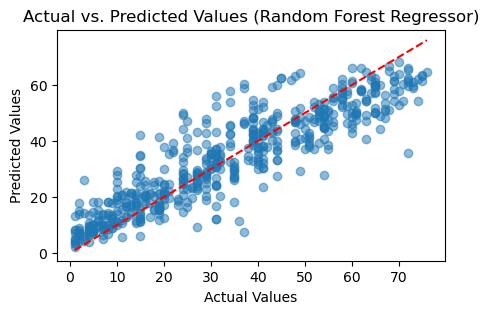

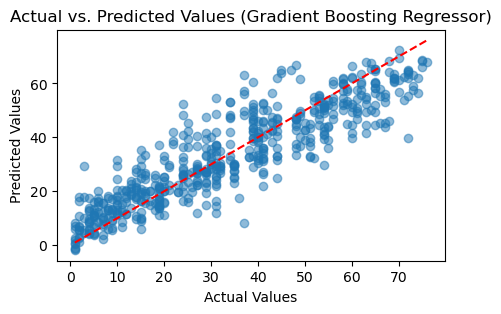

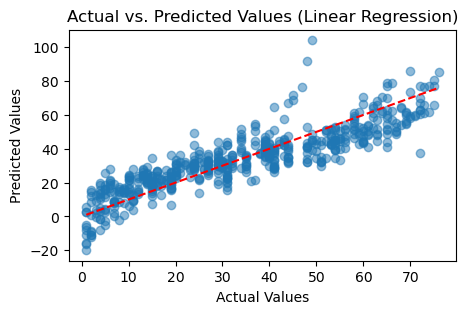

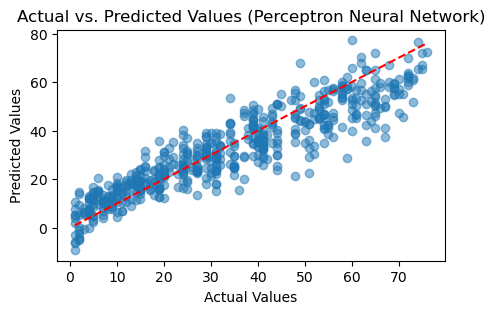

In [120]:

def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(5, 3))  # Set the figure size
    plt.scatter(y_test, y_pred, alpha=0.5)  # Plot a scatterplot of actual vs. predicted values
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Add a reference line for perfect predictions
    plt.xlabel('Actual Values')  # Label the x-axis
    plt.ylabel('Predicted Values')  # Label the y-axis
    plt.title(title)  # Add a title to the plot
    plt.show()  # Display the plot

# Plot the predictions for each model
plot_predictions(all_y_test, all_y_pred_rf, 'Actual vs. Predicted Values (Random Forest Regressor)')  
plot_predictions(all_y_test, all_y_pred_gb, 'Actual vs. Predicted Values (Gradient Boosting Regressor)')  
plot_predictions(all_y_test, all_y_pred_lr, 'Actual vs. Predicted Values (Linear Regression)')  
plot_predictions(all_y_test, all_y_pred_pnn, 'Actual vs. Predicted Values (Perceptron Neural Network)')  


In [ ]:
k   